In [ ]:
import pandas as pd
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt

import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch

SEED = 1551

random.seed(SEED)

np.random.seed(SEED)

torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # May slow down training but ensures reproducibility


# preperations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


making CSV out of text files and saving the imges path to be in the locak disk of colab

In [ ]:
# Function: process_pairs
# Processes pairs of image paths and labels from a text file.
#
# Parameters:
# - file_path (str): Path to the input text file.
#
# Returns:
# - List of tuples: Each tuple contains:
#   - Label (int): 1 for same person, 0 for different persons.
#   - img_1_path (str): Path to the first image.
#   - img_2_path (str): Path to the second image.
#
# Description:
# - For lines with three components, it generates paths for images of the same person.
# - For lines with four components, it generates paths for images of different persons.
#
# Outputs:
# - DataFrames `train_df` and `test_df` containing the processed pairs.
# - Saves these DataFrames as CSV files in Google Drive.

In [ ]:

# Define a function to process the pairs from a text file
def process_pairs(file_path):
    pairs = []
    with open(file_path, 'r') as f:
        lines = f.readlines()[1:]  # Skip the first line (number of pairs)
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 3:
                # Same person: Name and two image indices
                name, img1_idx, img2_idx = parts
                img1_path = f"/content/lfw2/{name}/{name}_{int(img1_idx):04d}.jpg"
                img2_path = f"/content/lfw2/{name}/{name}_{int(img2_idx):04d}.jpg"
                pairs.append((1, img1_path, img2_path))
            elif len(parts) == 4:
                # Different persons: Two names and their image indices
                name1, img1_idx, name2, img2_idx = parts
                img1_path = f"/content/lfw2/{name1}/{name1}_{int(img1_idx):04d}.jpg"
                img2_path = f"/content/lfw2/{name2}/{name2}_{int(img2_idx):04d}.jpg"
                pairs.append((0, img1_path, img2_path))
    return pairs

# Process Train.txt and Test.txt
train_file = "/content/drive/MyDrive/HW2_deep/Train.txt"
test_file = "/content/drive/MyDrive/HW2_deep/Test.txt"

train_pairs = process_pairs(train_file)
test_pairs = process_pairs(test_file)

# Create DataFrames
train_df = pd.DataFrame(train_pairs, columns=["label", "img_1_path", "img_2_path"])
test_df = pd.DataFrame(test_pairs, columns=["label", "img_1_path", "img_2_path"])

# Save the DataFrames to Google Drive
train_df.to_csv("/content/drive/MyDrive/HW2_deep/train_pairs.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/HW2_deep/test_pairs.csv", index=False)

print("CSV files with local paths have been created and saved in Google Drive.")


CSV files with local paths have been created and saved in Google Drive.


mooving the csv's to local disk in colab

In [ ]:
# Define source paths in Google Drive
train_csv_drive = "/content/drive/MyDrive/HW2_deep/train_pairs.csv"
test_csv_drive = "/content/drive/MyDrive/HW2_deep/test_pairs.csv"

# Define destination paths in Colab local disk
train_csv_local = "/content/train_pairs.csv"
test_csv_local = "/content/test_pairs.csv"

# Copy the LFW directory to Colab's local disk

# Copy the CSV files to Colab's local disk
shutil.copy(train_csv_drive, train_csv_local)
shutil.copy(test_csv_drive, test_csv_local)

print("Files have been copied to Colab's local disk:")
print(f"Train CSV: {train_csv_local}")
print(f"Test CSV: {test_csv_local}")


Files have been copied to Colab's local disk:
Train CSV: /content/train_pairs.csv
Test CSV: /content/test_pairs.csv


movving imges folder to local disk

In [ ]:
import os
import shutil
from concurrent.futures import ThreadPoolExecutor

def copy_file(src, dst):
    shutil.copy2(src, dst)

def copy_tree_parallel(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    with ThreadPoolExecutor() as executor:
        for root, _, files in os.walk(src_dir):
            relative_path = os.path.relpath(root, src_dir)
            target_root = os.path.join(dst_dir, relative_path)
            os.makedirs(target_root, exist_ok=True)
            for file in files:
                src_file = os.path.join(root, file)
                dst_file = os.path.join(target_root, file)
                executor.submit(copy_file, src_file, dst_file)

# Source and destination directories
lfw_dir_drive = "/content/drive/MyDrive/HW2_deep/lfw2"
lfw_dir_local = "/content/lfw2"

# Copy the directory using parallel threads
copy_tree_parallel(lfw_dir_drive, lfw_dir_local)

print("LFW directory has been copied to Colab's local disk (parallel):")
print(f"LFW directory: {lfw_dir_local}")


LFW directory has been copied to Colab's local disk (parallel):
LFW directory: /content/lfw2


# data analisys

In [ ]:
train_df = pd.read_csv(train_csv_local)
test_df = pd.read_csv(test_csv_local)

# Check the number of rows in both train and test datasets
train_rows = train_df.shape[0]
test_rows = test_df.shape[0]

print(f"number of rows in test :{test_rows}")
print(f"number of rows in train :{train_rows}")


number of rows in test :1000
number of rows in train :2200


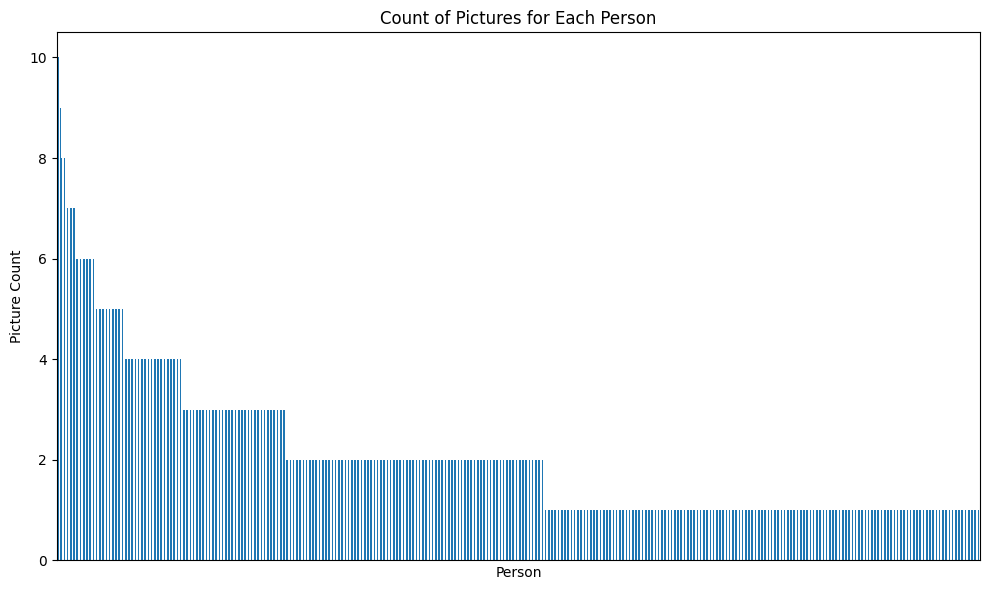

In [ ]:
# Create a temporary DataFrame for person counting
temp_df = pd.DataFrame()
temp_df['person'] = pd.concat([
    train_df['img_1_path'].apply(lambda x: x.split('/')[3]),  # Extract person name from img_1_path
    train_df['img_2_path'].apply(lambda x: x.split('/')[3])   # Extract person name from img_2_path
])

# Count occurrences of each person
person_counts = temp_df['person'].value_counts()

# Plot a bar chart without showing names on the X-axis
plt.figure(figsize=(10, 6))
person_counts.plot(kind='bar')
plt.title('Count of Pictures for Each Person')
plt.xlabel('Person')
plt.ylabel('Picture Count')
plt.xticks(ticks=[], rotation=0)  # Remove X-axis labels
plt.tight_layout()
plt.show()


In [ ]:
print(f"number of total pictures: {sum(person_counts)}")

number of total pictures: 4400


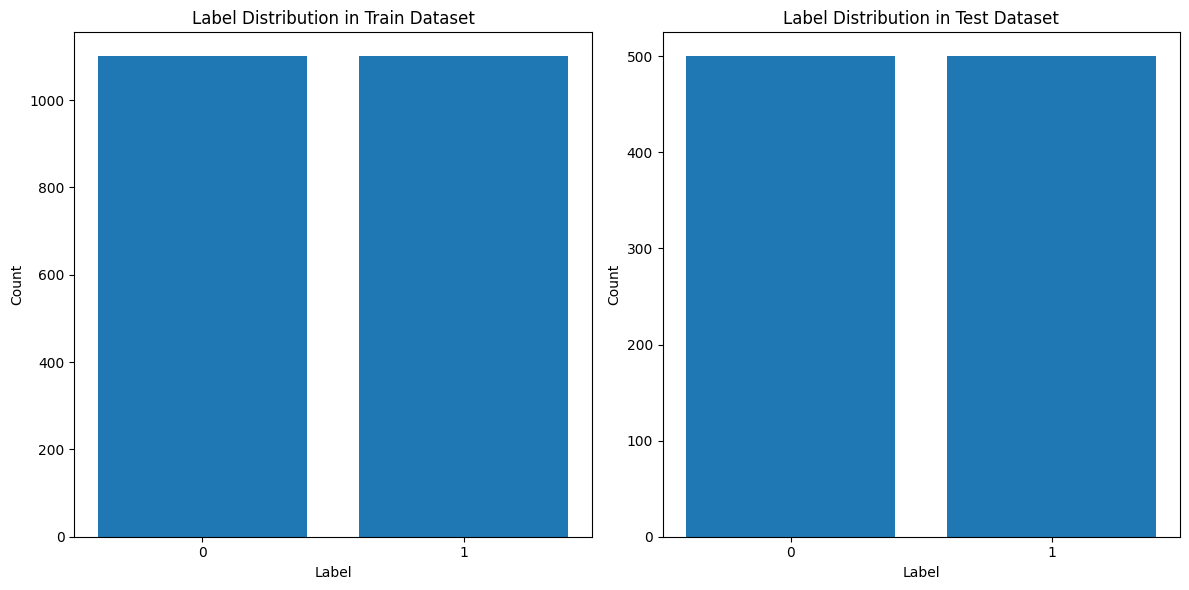

In [ ]:
# Count the occurrences of each label in train and test datasets
train_label_counts = train_df['label'].value_counts()
test_label_counts = test_df['label'].value_counts()

# Create bar plots for train and test label distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Train dataset
axes[0].bar(train_label_counts.index, train_label_counts.values)
axes[0].set_title('Label Distribution in Train Dataset')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticks(train_label_counts.index)

# Test dataset
axes[1].bar(test_label_counts.index, test_label_counts.values)
axes[1].set_title('Label Distribution in Test Dataset')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_xticks(test_label_counts.index)

plt.tight_layout()
plt.show()

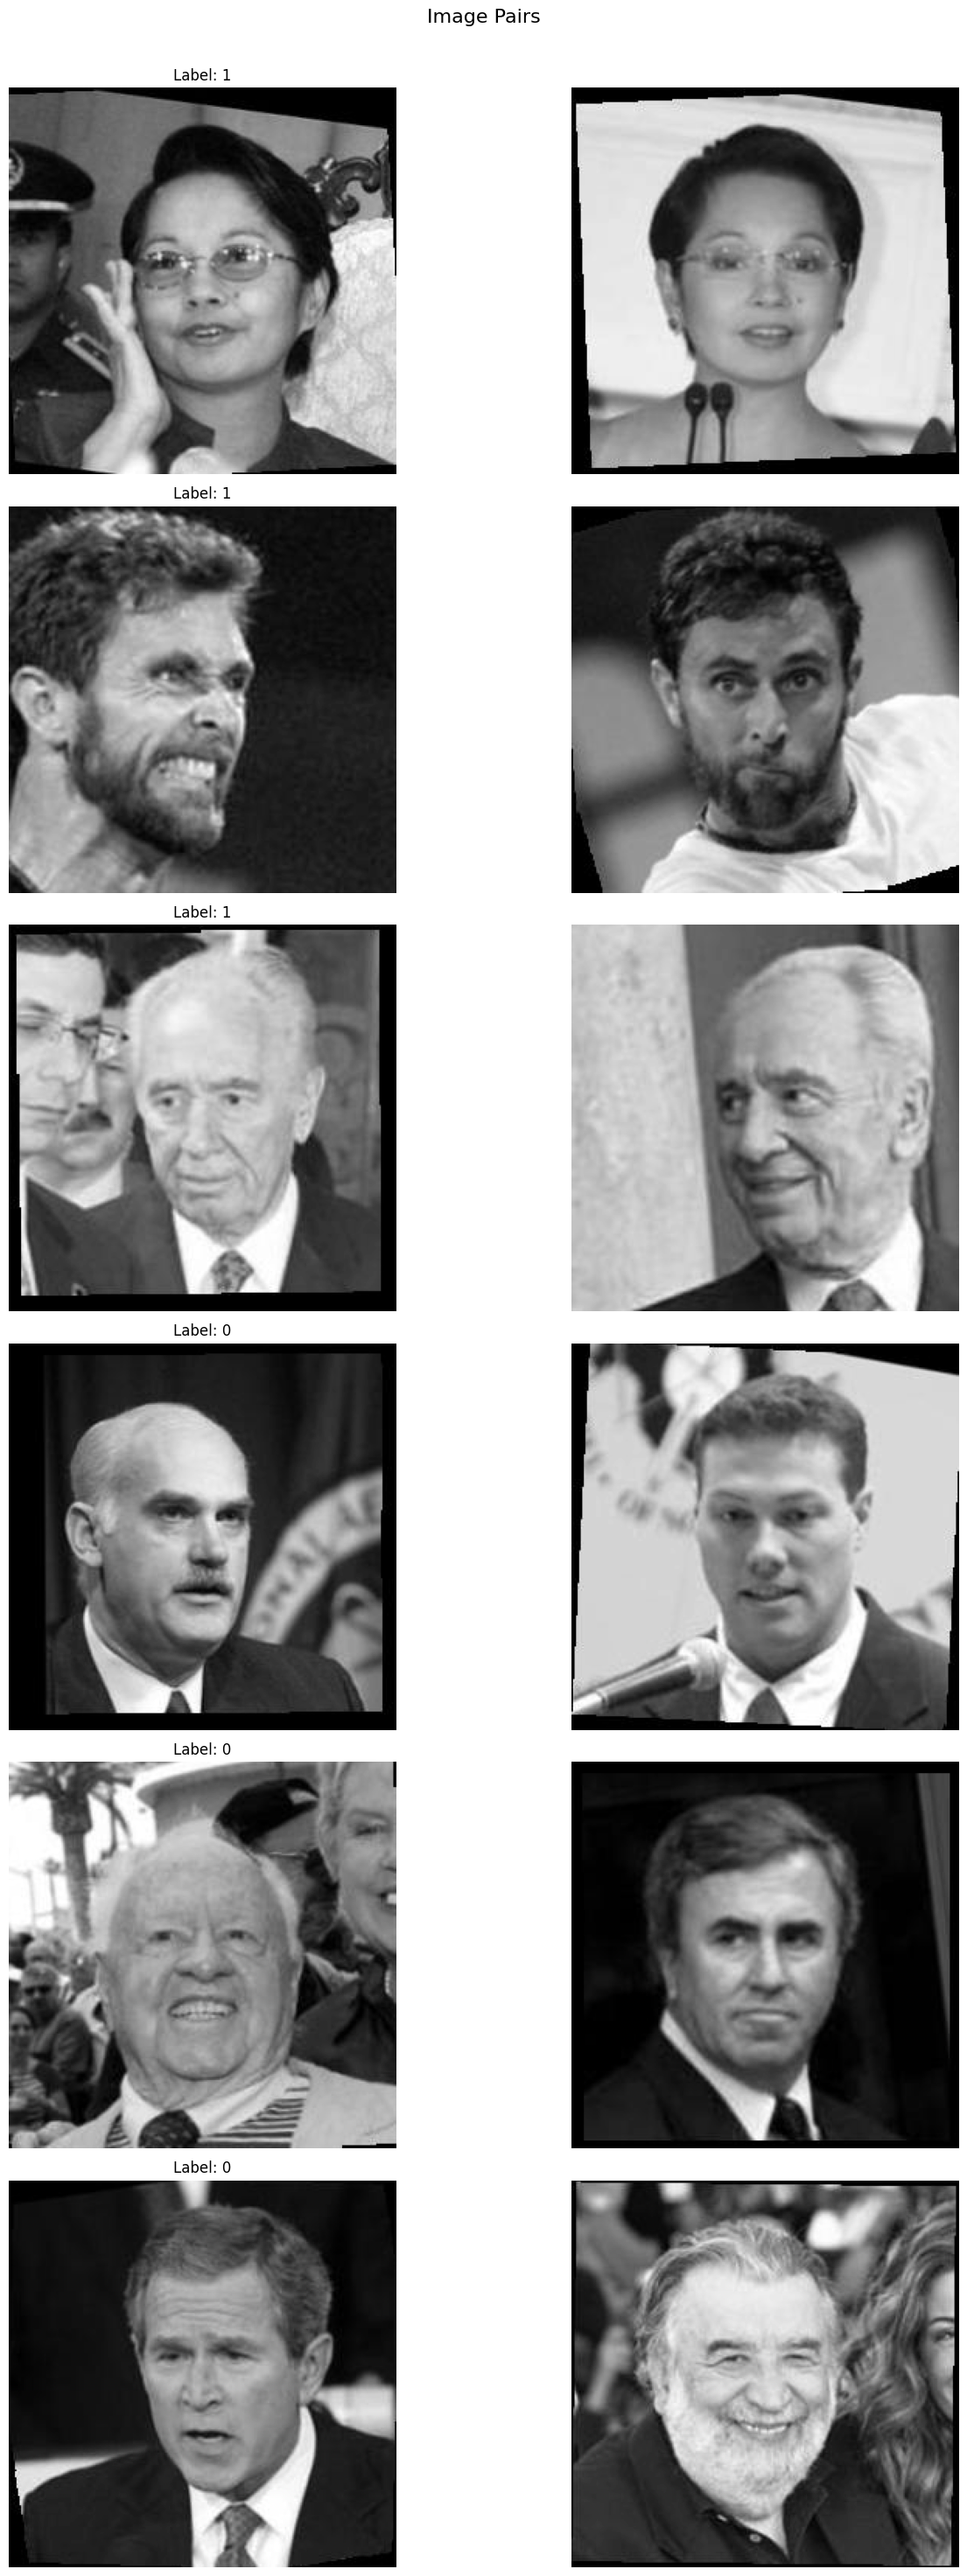

In [ ]:
def display_image_pairs(df, num_pairs=6):
    """Display pairs of grayscale images from the dataset.

    Args:
        df (pd.DataFrame): The DataFrame containing image paths and labels.
        num_pairs (int): Number of pairs to display (half same, half different).
    """
    # Split pairs into same-person and different-person
    same_person = df[df['label'] == 1].sample(n=num_pairs // 2)
    different_person = df[df['label'] == 0].sample(n=num_pairs // 2)

    pairs_to_display = pd.concat([same_person, different_person])

    fig, axes = plt.subplots(num_pairs, 2, figsize=(15, 5 * num_pairs))  # Create the correct number of subplots
    fig.suptitle("Image Pairs", fontsize=16)

    for idx, row in enumerate(pairs_to_display.itertuples()):
        img1 = cv2.imread(row.img_1_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
        img2 = cv2.imread(row.img_2_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image

        if img1 is None or img2 is None:
            print(f"Warning: One or both images could not be loaded: {row.img_1_path}, {row.img_2_path}")
            continue

        axes[idx, 0].imshow(img1, cmap='gray')  # Display grayscale image
        axes[idx, 0].axis('off')
        axes[idx, 0].set_title(f"Label: {row.label}")

        axes[idx, 1].imshow(img2, cmap='gray')  # Display grayscale image
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Use the updated function
display_image_pairs(train_df, num_pairs=6)


# data loaders

In [ ]:
# Class: MyDataset
# A custom PyTorch dataset for loading image pairs and their labels from a CSV file.
#
# Parameters:
# - csv_path (str): Path to the CSV file containing image paths and labels.
# - transform (callable, optional): Transformations to be applied to the images.
#   - Default: Resizes images to 105x105 pixels, converts them to grayscale, and transforms them into tensors.
#
# Methods:
# - __len__(): Returns the number of image pairs in the dataset.
# - __getitem__(idx): Returns the transformed images and label for the given index.
#   - Opens image files specified in the CSV.
#   - Applies the specified transformations.
#   - Converts the label to a PyTorch tensor.


In [ ]:
class MyDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((105, 105)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_path = self.df.iloc[idx]['img_1_path']
        img2_path = self.df.iloc[idx]['img_2_path']
        label = self.df.iloc[idx]['label']

        # Open the image files
        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        # Apply the transform to both images
        img1 = self.transform(img1)
        img2 = self.transform(img2)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.float32)
        return img1, img2, label

In [ ]:
# Plot loss and accuracy
def plot_metrics(metrics):
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["train_acc"], label="Train Accuracy")
    plt.plot(epochs, metrics["val_acc"], label="Val Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# base model from paper

In [ ]:
# Class: SiameseNetwork
# A PyTorch implementation of a Siamese neural network for comparing image pairs.
#
# Architecture:
# - Convolutional Layers:
#   - Conv1: 64 filters, kernel size 10x10, stride 1, followed by ReLU activation and 2x2 max-pooling.
#   - Conv2: 128 filters, kernel size 7x7, stride 1, followed by ReLU activation and 2x2 max-pooling.
#   - Conv3: 128 filters, kernel size 4x4, stride 1, followed by ReLU activation and 2x2 max-pooling.
#   - Conv4: 256 filters, kernel size 4x4, stride 1, followed by ReLU activation.
# - Fully Connected Layers:
#   - FC1: Input size 9216, output size 4096, followed by Sigmoid activation.
#   - Output Layer: Input size 4096, output size 1, followed by Sigmoid activation.
#
# Methods:
# - forward_once(x): Processes a single input through the convolutional and fully connected layers.
# - forward(input1, input2): Computes the absolute difference between the embeddings of two inputs
#   and passes it through the output layer to produce a similarity score.
#
# Output:
# - Produces a similarity score (between 0 and 1) indicating how similar the input images are.


In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, stride=1, padding=0),  # Valid padding
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0),
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid()
        )
        self.output_layer = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward_once(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        dis = torch.abs(output1 - output2)  # Absolute difference
        output = self.sigmoid(self.output_layer(dis))
        return output

# training base model with validation

In [ ]:
def train_siamese_network(model, dataset, config):
    """
    Train a Siamese network with validation.

    Args:
        model (nn.Module): The Siamese network model.
        dataset (Dataset): The dataset object (MyDataset).
        config (dict): Dictionary containing hyperparameters.
    Returns:
        dict: Dictionary containing loss and accuracy metrics.
    """
    # Extract parameters from config
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    lr = config["learning_rate"]
    val_split = config["validation_split"]
    device = config["device"]

    # Split dataset into training and validation
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Move model to device
    model = model.to(device)

    # Metrics storage
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct, total = 0, 0, 0
        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                outputs = model(img1, img2).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        # Save metrics
        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)
        metrics["train_acc"].append(train_acc)
        metrics["val_acc"].append(val_acc)

        # Print epoch summary
        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return metrics


In [ ]:
def test_siamese_network(model, test_dataset, config):
    """
    Test a trained Siamese network on the test dataset.

    Args:
        model (nn.Module): The trained Siamese network model.
        test_dataset (Dataset): The test dataset object.
        config (dict): Dictionary containing configuration parameters.
    Returns:
        dict: Dictionary containing test loss and accuracy.
    """
    # Create DataLoader for the test dataset
    test_loader = DataLoader(
        test_dataset,
        batch_size=config["batch_size"],
        shuffle=False,
        pin_memory=(config["device"].type == 'cuda')
    )

    # Move model to the specified device
    model = model.to(config["device"])
    model.eval()  # Set the model to evaluation mode

    criterion = nn.BCELoss()  # Loss function
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(config["device"]), img2.to(config["device"]), labels.to(config["device"])

            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute accuracy
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss = total_loss / len(test_loader)
    test_acc = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Return metrics
    return {"test_loss": test_loss, "test_acc": test_acc}


In [ ]:
config = {
    "epochs": 20,
    "batch_size": 128,
    "learning_rate": 0.0001,
    "validation_split": 0.2,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "csv_path": "train_pairs.csv",
    "resize_shape": (105, 105),
}


In [ ]:
# Dataset and model
dataset = MyDataset(
    csv_path=config["csv_path"]
)
model = SiameseNetwork()

# Train the model using the centralized configuration
metrics = train_siamese_network(model=model, dataset=dataset, config=config)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20] - Train Loss: 0.6922, Train Acc: 0.5437, Val Loss: 0.6908, Val Acc: 0.4841
Epoch [2/20] - Train Loss: 0.6839, Train Acc: 0.5352, Val Loss: 0.6843, Val Acc: 0.4841
Epoch [3/20] - Train Loss: 0.6633, Train Acc: 0.5795, Val Loss: 0.6802, Val Acc: 0.5273
Epoch [4/20] - Train Loss: 0.6438, Train Acc: 0.6159, Val Loss: 0.6650, Val Acc: 0.5955
Epoch [5/20] - Train Loss: 0.6232, Train Acc: 0.6443, Val Loss: 0.6458, Val Acc: 0.6318
Epoch [6/20] - Train Loss: 0.6039, Train Acc: 0.6739, Val Loss: 0.6307, Val Acc: 0.6386
Epoch [7/20] - Train Loss: 0.5785, Train Acc: 0.6932, Val Loss: 0.6352, Val Acc: 0.6568
Epoch [8/20] - Train Loss: 0.5628, Train Acc: 0.7159, Val Loss: 0.6188, Val Acc: 0.6591
Epoch [9/20] - Train Loss: 0.5382, Train Acc: 0.7386, Val Loss: 0.6177, Val Acc: 0.6523
Epoch [10/20] - Train Loss: 0.5135, Train Acc: 0.7580, Val Loss: 0.6136, Val Acc: 0.6523
Epoch [11/20] - Train Loss: 0.4906, Train Acc: 0.7670, Val Loss: 0.6533, Val Acc: 0.6295
Epoch [12/20] - Train Loss: 0.

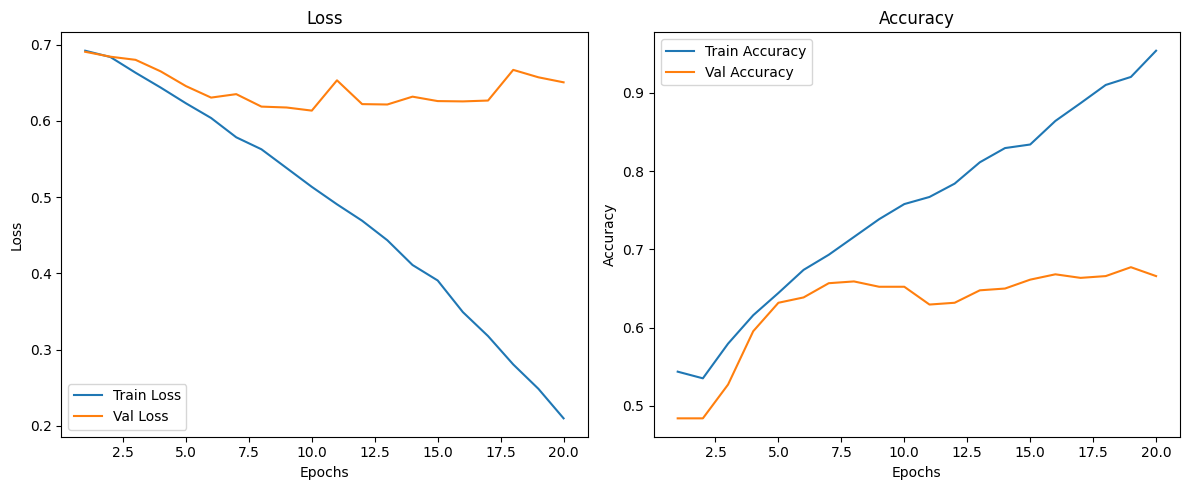

In [ ]:
plot_metrics(metrics)

In [ ]:
# Define the test dataset
test_dataset = MyDataset(
    csv_path="test_pairs.csv",
    transform=transforms.Compose([
        transforms.Resize(config["resize_shape"]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
)
# Test the model using the test set
test_metrics = test_siamese_network(
    model=model,
    test_dataset=test_dataset,
    config=config
)
print(test_metrics)

Test Loss: 0.7152, Test Accuracy: 0.6600
{'test_loss': 0.7152283042669296, 'test_acc': 0.66}


# improved model:

+ batchnorm
+ augmentations

In [ ]:
# Class: SiameseNetworkimproved
# Implements an improved Siamese network with batch normalization and ReLU activations.

# Constructor (__init__):
# - Initializes convolutional layers with:
#   - Conv2D layers followed by BatchNorm, ReLU activation, and max-pooling.
# - Adds a fully connected layer with ReLU activation for feature extraction.
# - Output layer applies a Sigmoid function to produce similarity scores.

# Method: forward_once
# - Processes a single input through the convolutional and fully connected layers.

# Method: forward
# - Processes two inputs through the network.
# - Computes the absolute difference between embeddings.
# - Passes the difference through the output layer to compute similarity.


In [ ]:
class SiameseNetworkimproved(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU()  # Changed from Sigmoid to ReLU for better activation in intermediate layers
        )
        self.output_layer = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward_once(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        dis = torch.abs(output1 - output2)
        output = self.sigmoid(self.output_layer(dis))
        return output


In [ ]:
config = {
    "epochs": 20,
    "batch_size": 128,
    "learning_rate": 0.0001,
    "validation_split": 0.2,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "csv_path": "train_pairs.csv",
    "resize_shape": (105, 105),
}


In [ ]:
# Dataset and model
dataset = MyDataset(
    csv_path=config["csv_path"],
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
        transforms.RandomRotation(degrees=15),  # Randomly rotate images
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
        transforms.Resize(config["resize_shape"]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
)

model = SiameseNetworkimproved()

# Train the model using the centralized configuration
metrics = train_siamese_network(model=model, dataset=dataset, config=config)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20] - Train Loss: 0.7791, Train Acc: 0.5085, Val Loss: 0.6924, Val Acc: 0.5159
Epoch [2/20] - Train Loss: 0.6544, Train Acc: 0.5750, Val Loss: 0.6698, Val Acc: 0.6227
Epoch [3/20] - Train Loss: 0.5967, Train Acc: 0.7182, Val Loss: 0.6240, Val Acc: 0.6659
Epoch [4/20] - Train Loss: 0.5587, Train Acc: 0.7273, Val Loss: 0.5807, Val Acc: 0.7068
Epoch [5/20] - Train Loss: 0.5190, Train Acc: 0.7602, Val Loss: 0.5612, Val Acc: 0.7295
Epoch [6/20] - Train Loss: 0.4837, Train Acc: 0.7892, Val Loss: 0.5478, Val Acc: 0.7364
Epoch [7/20] - Train Loss: 0.4520, Train Acc: 0.8074, Val Loss: 0.5413, Val Acc: 0.7409
Epoch [8/20] - Train Loss: 0.4228, Train Acc: 0.8392, Val Loss: 0.5372, Val Acc: 0.7250
Epoch [9/20] - Train Loss: 0.4028, Train Acc: 0.8455, Val Loss: 0.5079, Val Acc: 0.7455
Epoch [10/20] - Train Loss: 0.3717, Train Acc: 0.8648, Val Loss: 0.5311, Val Acc: 0.7250
Epoch [11/20] - Train Loss: 0.3345, Train Acc: 0.8909, Val Loss: 0.5086, Val Acc: 0.7659
Epoch [12/20] - Train Loss: 0.

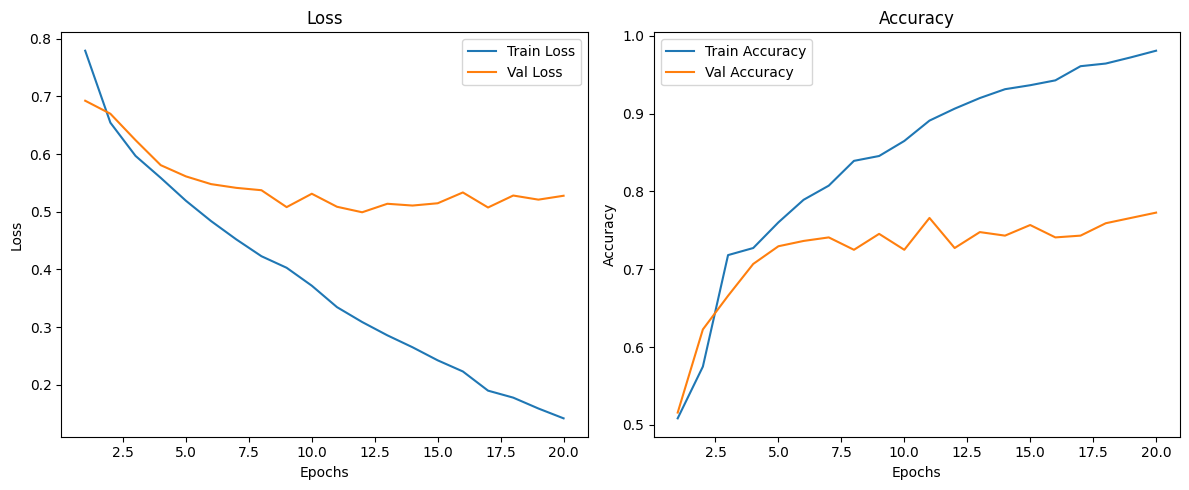

In [ ]:
plot_metrics(metrics)

In [ ]:
# Define the test dataset
test_dataset = MyDataset(
    csv_path="test_pairs.csv"
)
# Test the model using the test set
test_metrics = test_siamese_network(
    model=model,
    test_dataset=test_dataset,
    config=config
)
print(test_metrics)

Test Loss: 0.5501, Test Accuracy: 0.7500
{'test_loss': 0.5501449555158615, 'test_acc': 0.75}


# improved model 2
+ L2 regularization
+ LR optimizer
+ dropouts


In [ ]:
def train_siamese_network(model, dataset, config):
    """
    Train a Siamese network with validation.

    Args:
        model (nn.Module): The Siamese network model.
        dataset (Dataset): The dataset object (MyDataset).
        config (dict): Dictionary containing hyperparameters.
    Returns:
        dict: Dictionary containing loss and accuracy metrics.
    """
    # Extract parameters from config
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    lr = config["learning_rate"]
    val_split = config["validation_split"]
    device = config["device"]

    # Split dataset into training and validation
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Learning rate scheduler
    criterion = nn.BCELoss()

    # Move model to device
    model = model.to(device)

    # Metrics storage
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct, total = 0, 0, 0
        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                outputs = model(img1, img2).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        # Save metrics
        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)
        metrics["train_acc"].append(train_acc)
        metrics["val_acc"].append(val_acc)

        scheduler.step()

        # Print epoch summary
        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f},"
              f"LR: {scheduler.get_last_lr()[0]:.10f}")

    return metrics


In [ ]:
# Class: SiameseNetworkimproved2
# Extends the Siamese network with dropout for regularization.

# Constructor (__init__):
# - Convolutional Layers:
#   - Four Conv2D layers with BatchNorm, ReLU activation, and max-pooling.
# - Fully Connected Layers:
#   - Adds a fully connected layer with ReLU activation and a dropout layer (p=0.5) for regularization.
# - Output Layer:
#   - A final linear layer followed by a Sigmoid function to compute similarity scores.

# Method: forward_once
# - Processes a single input through the network's layers, including dropout in the fully connected layers.

# Method: forward
# - Processes two inputs through the network.
# - Computes the absolute difference between embeddings.
# - Produces a similarity score through the output layer.


In [ ]:
class SiameseNetworkimproved2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
          nn.Linear(256 * 6 * 6, 4096),
          nn.ReLU(),
          nn.Dropout(p=0.5),  # Dropout layer
        )
        self.output_layer = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward_once(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        dis = torch.abs(output1 - output2)
        output = self.sigmoid(self.output_layer(dis))
        return output


In [ ]:
config = {
    "epochs": 20,
    "batch_size": 128,
    "learning_rate": 0.0001,
    "validation_split": 0.2,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "csv_path": "train_pairs.csv",
    "resize_shape": (105, 105),
}


In [ ]:
# Dataset and model
dataset = MyDataset(
    csv_path=config["csv_path"],
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
        transforms.RandomRotation(degrees=15),  # Randomly rotate images
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
        transforms.Resize(config["resize_shape"]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
)

model = SiameseNetworkimproved2()

# Train the model using the centralized configuration
metrics = train_siamese_network(model=model, dataset=dataset, config=config)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20] - Train Loss: 0.8086, Train Acc: 0.5028, Val Loss: 0.6939, Val Acc: 0.4886,LR: 0.0001000000
Epoch [2/20] - Train Loss: 0.7649, Train Acc: 0.4994, Val Loss: 0.6914, Val Acc: 0.5591,LR: 0.0001000000
Epoch [3/20] - Train Loss: 0.6865, Train Acc: 0.5557, Val Loss: 0.6791, Val Acc: 0.5750,LR: 0.0001000000
Epoch [4/20] - Train Loss: 0.6657, Train Acc: 0.5886, Val Loss: 0.6694, Val Acc: 0.5341,LR: 0.0001000000
Epoch [5/20] - Train Loss: 0.6683, Train Acc: 0.5847, Val Loss: 0.6668, Val Acc: 0.5409,LR: 0.0000100000
Epoch [6/20] - Train Loss: 0.6314, Train Acc: 0.6392, Val Loss: 0.6669, Val Acc: 0.5477,LR: 0.0000100000
Epoch [7/20] - Train Loss: 0.6376, Train Acc: 0.6545, Val Loss: 0.6622, Val Acc: 0.5386,LR: 0.0000100000
Epoch [8/20] - Train Loss: 0.6317, Train Acc: 0.6705, Val Loss: 0.6731, Val Acc: 0.5227,LR: 0.0000100000
Epoch [9/20] - Train Loss: 0.6294, Train Acc: 0.6557, Val Loss: 0.6669, Val Acc: 0.5364,LR: 0.0000100000
Epoch [10/20] - Train Loss: 0.6246, Train Acc: 0.6670, 

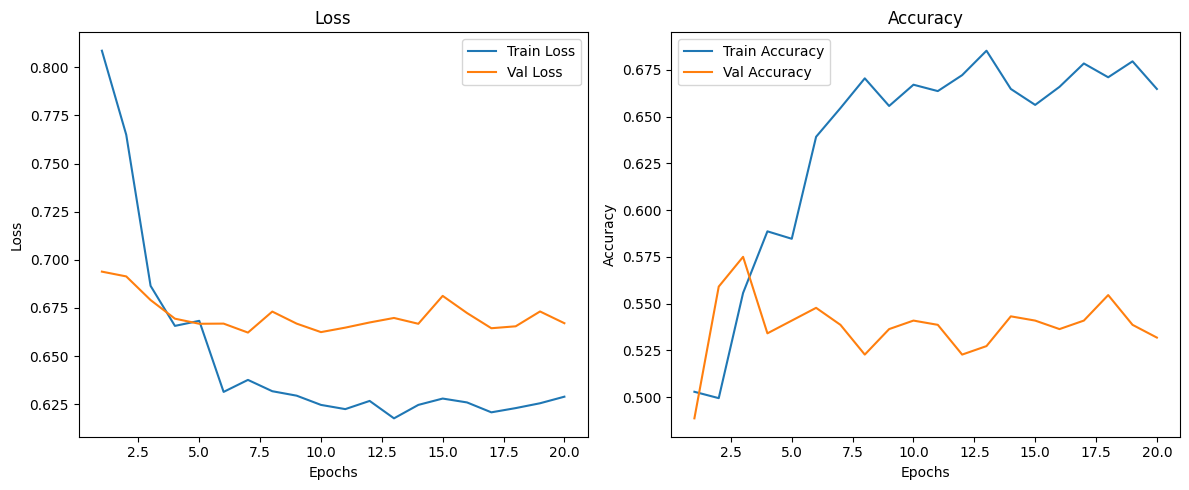

In [ ]:
plot_metrics(metrics)

In [ ]:
# Define the test dataset
test_dataset = MyDataset(
    csv_path="test_pairs.csv",
    transform=transforms.Compose([
        transforms.Resize(config["resize_shape"]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
)
# Test the model using the test set
test_metrics = test_siamese_network(
    model=model,
    test_dataset=test_dataset,
    config=config
)
print(test_metrics)

Test Loss: 0.6596, Test Accuracy: 0.5290
{'test_loss': 0.6595574766397476, 'test_acc': 0.529}


# improved model 3

+ removed dropouts
+ removed L2
+ added earlystop
+ MSELoss

In [ ]:
def train_siamese_network(model, dataset, config):
    """
    Train a Siamese network with validation, learning rate scheduling, and early stopping.

    Args:
        model (nn.Module): The Siamese network model.
        dataset (Dataset): The dataset object (MyDataset).
        config (dict): Dictionary containing configuration parameters.
    Returns:
        dict: Dictionary containing loss and accuracy metrics.
    """
    # Extract parameters from config
    epochs = config["epochs"]
    batch_size = config["batch_size"]
    lr = config["learning_rate"]
    val_split = config["validation_split"]
    device = config["device"]
    early_stop_patience = config.get("early_stop_patience", 5)  # Default patience: 5 epochs

    # Split dataset into training and validation
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = nn.MSELoss()

    # Move model to device
    model = model.to(device)

    # Metrics storage
    metrics = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    # Early stopping variables
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, correct, total = 0, 0, 0
        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for img1, img2, labels in val_loader:
                img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
                outputs = model(img1, img2).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (outputs > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total

        # Save metrics
        metrics["train_loss"].append(train_loss)
        metrics["val_loss"].append(val_loss)
        metrics["train_acc"].append(train_acc)
        metrics["val_acc"].append(val_acc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
            print(f"Validation loss improved to {best_val_loss:.4f}. Saving model...")
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

        # Step the scheduler
        scheduler.step()

        # Print epoch summary
        print(f"Epoch [{epoch + 1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"LR: {scheduler.get_last_lr()[0]:.10f}")

    return metrics


In [ ]:
# Class: SiameseNetworkimproved3
# Refines the Siamese network by simplifying regularization and maintaining batch normalization.

# Constructor (__init__):
# - Convolutional Layers:
#   - Four Conv2D layers with BatchNorm, ReLU activation, and max-pooling.
# - Fully Connected Layers:
#   - Includes a fully connected layer with ReLU activation.
# - Output Layer:
#   - A final linear layer followed by a Sigmoid function to compute similarity scores.

# Method: forward_once
# - Processes a single input through the convolutional and fully connected layers.

# Method: forward
# - Processes two inputs through the network.
# - Computes the absolute difference between embeddings.
# - Outputs a similarity score through the final layer.


In [ ]:
class SiameseNetworkimproved3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, stride=1, padding=0),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(256),  # Batch normalization
            nn.ReLU()
        )
        self.fc_layers = nn.Sequential(
          nn.Linear(256 * 6 * 6, 4096),
          nn.ReLU()
        )
        self.output_layer = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

    def forward_once(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        dis = torch.abs(output1 - output2)
        output = self.sigmoid(self.output_layer(dis))
        return output


In [ ]:
config = {
    "epochs": 20,
    "batch_size": 128,
    "learning_rate": 0.0001,
    "validation_split": 0.2,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "csv_path": "train_pairs.csv",
    "resize_shape": (105, 105),
    "early_stop_patience": 5
}


In [ ]:
# Dataset and model
dataset = MyDataset(
    csv_path=config["csv_path"],
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
        transforms.RandomRotation(degrees=15),  # Randomly rotate images
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
        transforms.Resize(config["resize_shape"]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
)

model = SiameseNetworkimproved3()

# Train the model using the centralized configuration
metrics = train_siamese_network(model=model, dataset=dataset, config=config)


Validation loss improved to 0.2494. Saving model...
Epoch [1/20] - Train Loss: 0.2915, Train Acc: 0.5057, Val Loss: 0.2494, Val Acc: 0.5409, LR: 0.0001000000
Validation loss improved to 0.2369. Saving model...
Epoch [2/20] - Train Loss: 0.2284, Train Acc: 0.6034, Val Loss: 0.2369, Val Acc: 0.6023, LR: 0.0001000000
Validation loss improved to 0.2184. Saving model...
Epoch [3/20] - Train Loss: 0.2019, Train Acc: 0.6926, Val Loss: 0.2184, Val Acc: 0.6909, LR: 0.0001000000
Validation loss improved to 0.1996. Saving model...
Epoch [4/20] - Train Loss: 0.1819, Train Acc: 0.7375, Val Loss: 0.1996, Val Acc: 0.6932, LR: 0.0001000000
Validation loss improved to 0.1929. Saving model...
Epoch [5/20] - Train Loss: 0.1646, Train Acc: 0.7926, Val Loss: 0.1929, Val Acc: 0.7205, LR: 0.0000100000
Validation loss improved to 0.1926. Saving model...
Epoch [6/20] - Train Loss: 0.1500, Train Acc: 0.8159, Val Loss: 0.1926, Val Acc: 0.7023, LR: 0.0000100000
Validation loss improved to 0.1834. Saving model...


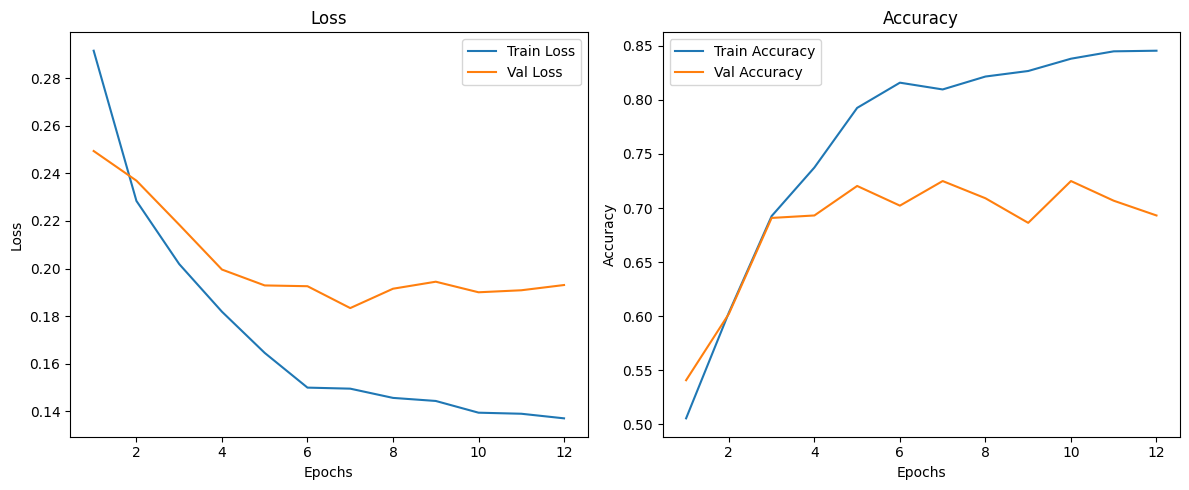

In [ ]:
plot_metrics(metrics)

In [ ]:
# Define the test dataset
test_dataset = MyDataset(
    csv_path="test_pairs.csv",
    transform=transforms.Compose([
        transforms.Resize(config["resize_shape"]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
)
# Test the model using the test set
test_metrics = test_siamese_network(
    model=model,
    test_dataset=test_dataset,
    config=config
)
print(test_metrics)

Test Loss: 0.5455, Test Accuracy: 0.7260
{'test_loss': 0.5455007702112198, 'test_acc': 0.726}


# grid search for best model

In [ ]:
from itertools import product

# Define parameter grid
param_grid = {
    "epochs": [10, 20, 30],
    "batch_size": [64, 128, 256],
    "learning_rate": [0.001, 0.0001, 0.00001],
    "early_stop_patience": [3, 5, 7]
}

# Get all combinations of parameters
grid_search_params = list(product(
    param_grid["epochs"],
    param_grid["batch_size"],
    param_grid["learning_rate"],
    param_grid["early_stop_patience"]
))

# Grid search
best_model = None
best_metrics = None
best_params = None
lowest_val_loss = float("inf")

for params in grid_search_params:
    print(f"Training with parameters: epochs={params[0]}, batch_size={params[1]}, "
          f"learning_rate={params[2]}, early_stop_patience={params[3]}")

    # Update configuration
    config = {
        "epochs": params[0],
        "batch_size": params[1],
        "learning_rate": params[2],
        "validation_split": 0.2,
        "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "csv_path": "train_pairs.csv",
        "resize_shape": (105, 105),
        "early_stop_patience": params[3]
    }

    # Reinitialize dataset and model
    dataset = MyDataset(
        csv_path=config["csv_path"],
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
            transforms.RandomRotation(degrees=15),  # Randomly rotate images
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness and contrast
            transforms.Resize(config["resize_shape"]),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])
    )
    model = SiameseNetworkimproved3()

    # Train the model
    metrics = train_siamese_network(model=model, dataset=dataset, config=config)

    # Evaluate performance
    val_loss = metrics["val_loss"][-1]
    if val_loss < lowest_val_loss:
        lowest_val_loss = val_loss
        best_model = model
        best_metrics = metrics
        best_params = params

print("\nBest Configuration:")
print(f"epochs={best_params[0]}, batch_size={best_params[1]}, "
      f"learning_rate={best_params[2]}, early_stop_patience={best_params[3]}")
print("Validation Loss:", lowest_val_loss)

# Save the best model
torch.save(best_model.state_dict(), "best_model_gridsearch.pth")


Training with parameters: epochs=10, batch_size=64, learning_rate=0.001, early_stop_patience=3
Validation loss improved to 0.4888. Saving model...
Epoch [1/10] - Train Loss: 0.4266, Train Acc: 0.5284, Val Loss: 0.4888, Val Acc: 0.4886, LR: 0.0010000000
Validation loss improved to 0.4715. Saving model...
Epoch [2/10] - Train Loss: 0.4529, Train Acc: 0.5176, Val Loss: 0.4715, Val Acc: 0.5091, LR: 0.0010000000
No improvement in validation loss for 1 epoch(s).
Epoch [3/10] - Train Loss: 0.5013, Train Acc: 0.4903, Val Loss: 0.4954, Val Acc: 0.5045, LR: 0.0010000000
No improvement in validation loss for 2 epoch(s).
Epoch [4/10] - Train Loss: 0.5027, Train Acc: 0.4983, Val Loss: 0.4906, Val Acc: 0.5068, LR: 0.0010000000
No improvement in validation loss for 3 epoch(s).
Early stopping triggered.
Training with parameters: epochs=10, batch_size=64, learning_rate=0.001, early_stop_patience=5
Validation loss improved to 0.4791. Saving model...
Epoch [1/10] - Train Loss: 0.4342, Train Acc: 0.5199, 

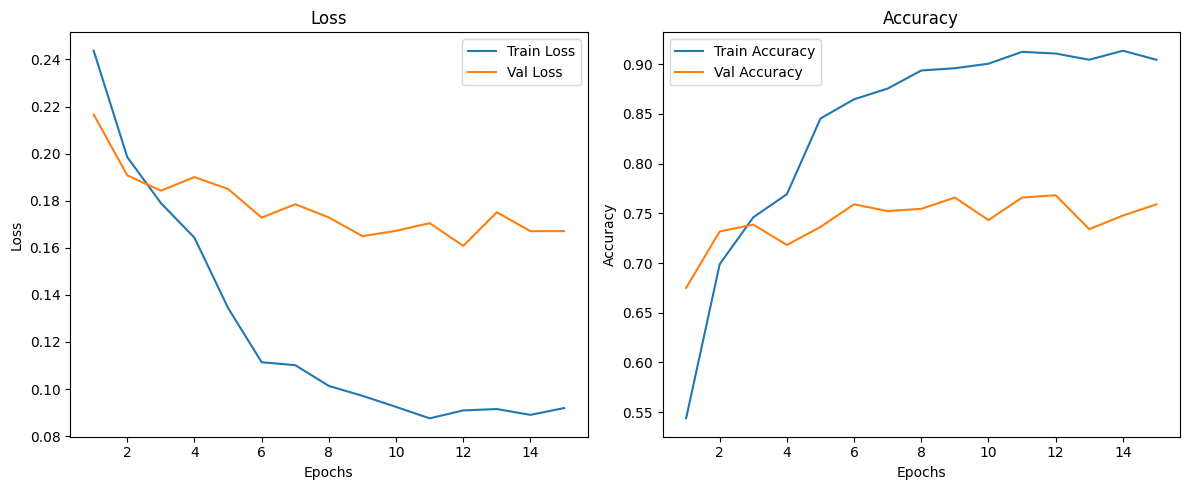

Test Loss: 0.5332, Test Accuracy: 0.7280
Test Metrics:
Test Loss: 0.5332
Test Accuracy: 0.7280


In [ ]:
# Plot the training and validation metrics for the best model
plot_metrics(best_metrics)

# Define the test dataset
test_dataset = MyDataset(
    csv_path="test_pairs.csv",
    transform=transforms.Compose([
        transforms.Resize(config["resize_shape"]),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
)

# Test the best model using the test set
# Ensure the best model is loaded onto the appropriate device
best_model = best_model.to(config["device"])

test_metrics = test_siamese_network(
    model=best_model,
    test_dataset=test_dataset,
    config=config
)

# Print the test performance metrics
print("Test Metrics:")
print(f"Test Loss: {test_metrics['test_loss']:.4f}")
print(f"Test Accuracy: {test_metrics['test_acc']:.4f}")


# correct and missed classified samples

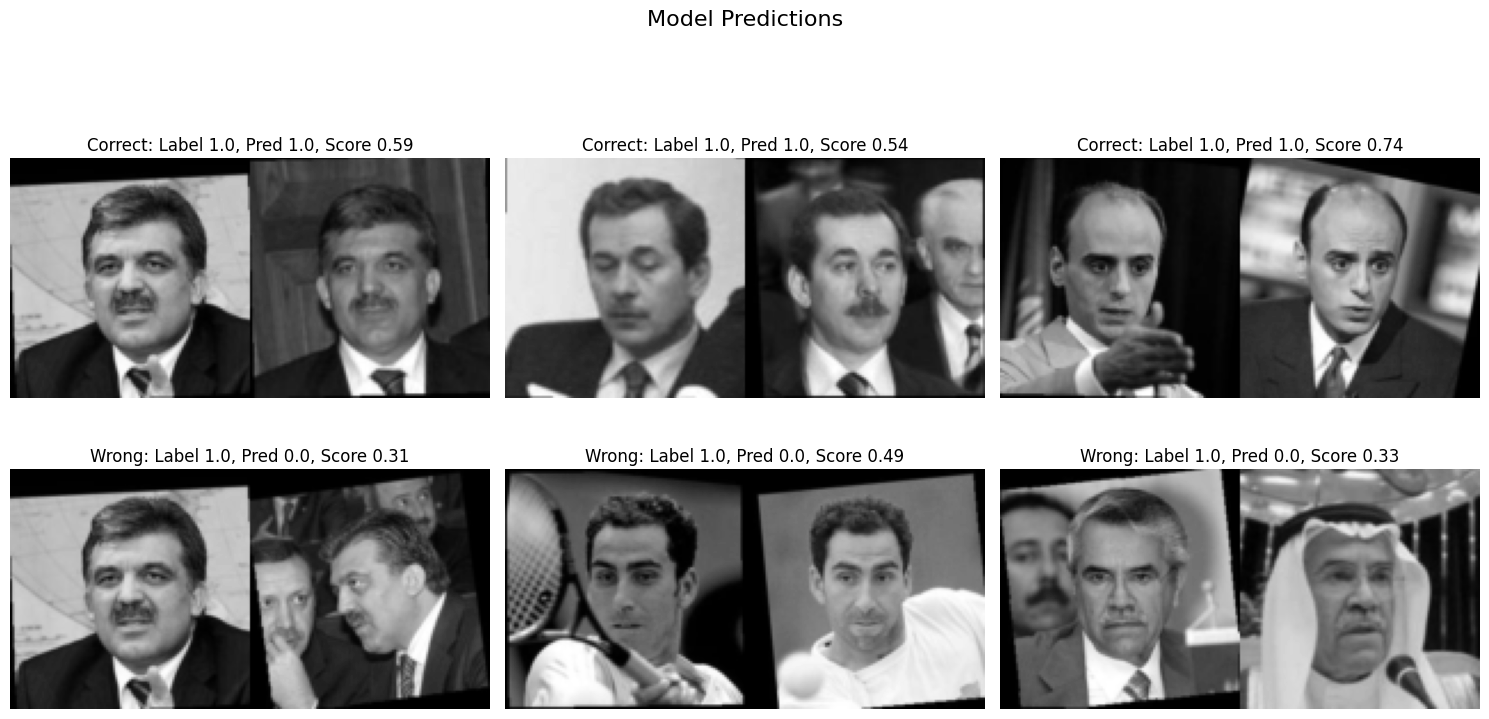

In [ ]:


def visualize_predictions(model, test_dataset, config, num_correct=3, num_wrong=3):
    """
    Visualize correctly classified and misclassified examples.

    Args:
        model (nn.Module): The trained Siamese network model.
        test_dataset (Dataset): The test dataset.
        config (dict): Configuration dictionary.
        num_correct (int): Number of correctly classified examples to display.
        num_wrong (int): Number of misclassified examples to display.
    """
    model.eval()
    model.to(config["device"])

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    correct_examples = []
    wrong_examples = []

    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(config["device"]), img2.to(config["device"]), label.to(config["device"])
            output = model(img1, img2).squeeze()
            pred = (output > 0.5).float()

            is_correct = (pred == label).item()
            example = (img1.cpu().squeeze(0), img2.cpu().squeeze(0), label.item(), pred.item(), output.item())

            if is_correct and len(correct_examples) < num_correct:
                correct_examples.append(example)
            elif not is_correct and len(wrong_examples) < num_wrong:
                wrong_examples.append(example)

            if len(correct_examples) >= num_correct and len(wrong_examples) >= num_wrong:
                break

    # Visualization
    fig, axes = plt.subplots(2, max(num_correct, num_wrong), figsize=(15, 8))
    fig.suptitle("Model Predictions", fontsize=16)

    # Plot correct examples
    for idx, (img1, img2, label, pred, score) in enumerate(correct_examples):
        concatenated_img = torch.cat([img1, img2], dim=2).squeeze(0)  # Concatenate and remove batch dimension
        axes[0, idx].imshow(concatenated_img, cmap="gray")
        axes[0, idx].axis("off")
        axes[0, idx].set_title(f"Correct: Label {label}, Pred {pred:.1f}, Score {score:.2f}")

    # Plot wrong examples
    for idx, (img1, img2, label, pred, score) in enumerate(wrong_examples):
        concatenated_img = torch.cat([img1, img2], dim=2).squeeze(0)  # Concatenate and remove batch dimension
        axes[1, idx].imshow(concatenated_img, cmap="gray")
        axes[1, idx].axis("off")
        axes[1, idx].set_title(f"Wrong: Label {label}, Pred {pred:.1f}, Score {score:.2f}")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Load the trained model
model.load_state_dict(torch.load("best_model.pth", weights_only=True))  # Set weights_only=True for safe loading

# Visualize predictions
visualize_predictions(model, test_dataset, config, num_correct=3, num_wrong=3)
